## Cytokit Cell Size Analysis

Cell Counter: 
https://www.thermofisher.com/us/en/home/life-science/cell-analysis/cell-analysis-instruments/automated-cell-counters/countess-ii-automated-cell-counter.html

pip install git+https://github.com/bpteague/cytoflow

In [1]:
import cytoflow as flow

/Users/eczech/anaconda3/envs/cytoflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/eczech/anaconda3/envs/cytoflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/eczech/anaconda3/envs/cytoflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/eczech/anaconda3/envs/cytoflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/eczech/anaconda3/envs/cytoflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


In [2]:
%matplotlib inline
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

experiments = pd.read_csv('experiments.csv')
#variants = ['v00', 'v01', 'v02', 'v03']
variant = 'v01'
data_dir = '/Volumes/disk1/cytokit/cell-size/20181024'

In [3]:
experiments

,exp,stepz,numz,mag
0,20181024-d38-act-20X-5by5,1000,29,20x
1,20181024-d38-unstim-20X-5by5,1000,25,20x
2,20181024-d39-act-20x-5by5,500,33,20x
3,20181024-d39-unstim-20x-5by5,500,25,20x
4,20181024-jurkat-20X-5by5,2000,23,20x
5,20181024-jurkat2-20X-5by5,500,25,20x
6,20181026-pmel-act-20x-5by5,1000,23,20x
7,20181026-pmel-us-20x-5by5,1000,25,20x
8,20181026-pmel-act-60x-5b5,500,22,60x


In [14]:
tubes = [
    flow.Tube(
        file=osp.join(data_dir, r['exp'], 'output', variant, 'cytometry', 'data.fcs'),
        conditions = {"ido": i}
    )
    for i, r in experiments.iterrows()
]
import_op = flow.ImportOp(
    conditions = {"ido" : "int"},
    tubes = tubes,
    channels = {
        "id": "id",
        "celldiameter": "celldiameter",
        "nucleusdiameter": "nucleusdiameter",
        "niDAPI": "niDAPI",
        "ciDAPI": "ciDAPI",
        "niMEMB": "niMEMB",
        "ciMEMB": "ciMEMB"
    }
)
ex = import_op.apply()

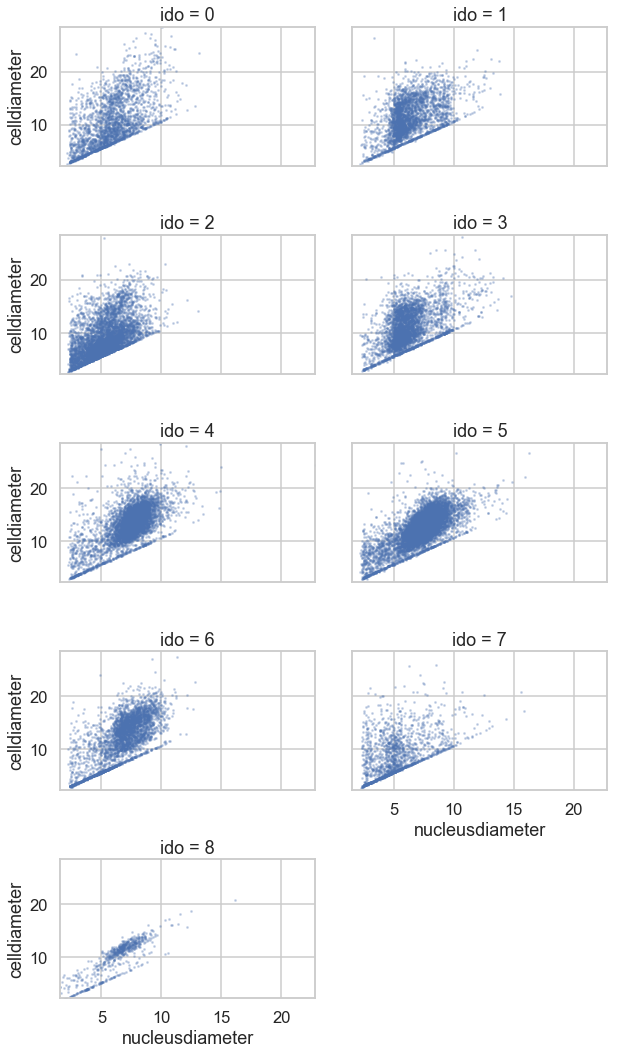

In [15]:
flow.ScatterplotView(xchannel = "nucleusdiameter",
                     xscale = "linear",
                     ychannel = "celldiameter",
                     yscale = "linear",
                     xfacet='ido').plot(ex, col_wrap=2)

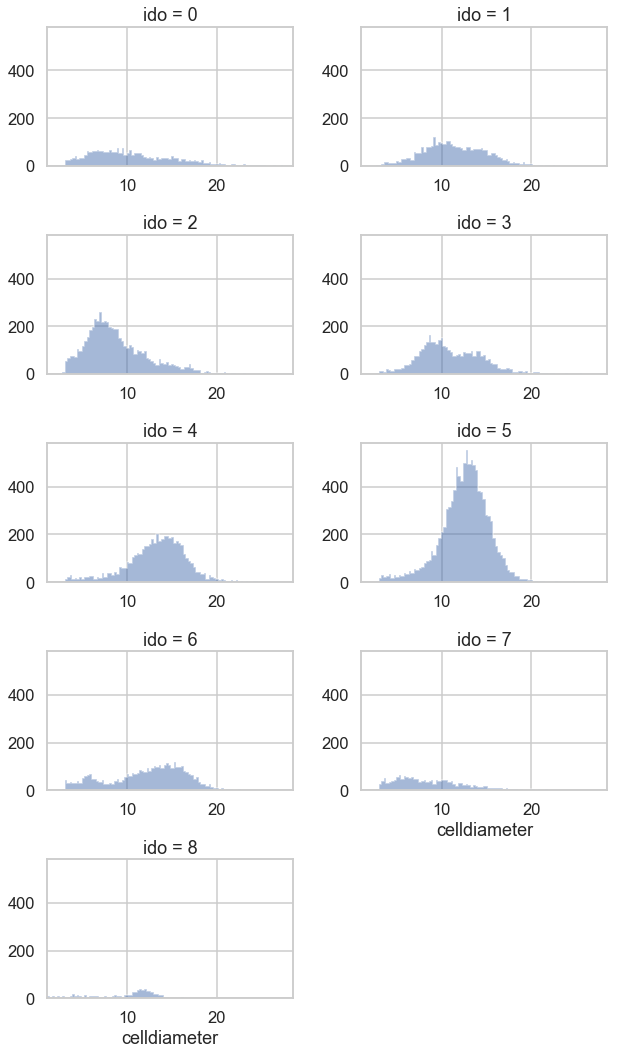

In [5]:
flow.HistogramView(scale = 'linear', channel = 'celldiameter', xfacet='ido')\
    .plot(ex, col_wrap=2, min_quantile=0, max_quantile=1, sharey=False, sharex=False)

In [16]:
fp = flow.GaussianMixtureOp(name = "KMeans",
                    by = ['ido'],
                  channels = ["nucleusdiameter", "celldiameter"],
                  scale = {"nucleusdiameter" : "linear",
                               "celldiameter" : "linear"},
                  num_components = 1, sigma=1)
fp.estimate(ex)
ex2 = fp.apply(ex)

/Users/eczech/repos/misc/python/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'KMeans_1'


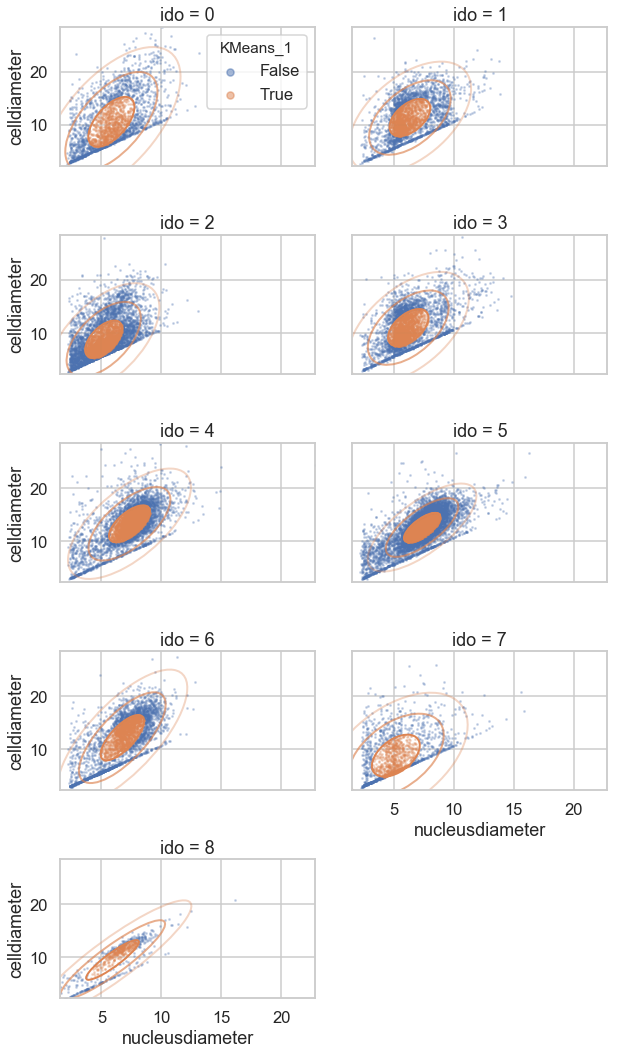

In [17]:
fp.default_view(xfacet='ido').plot(ex2, col_wrap=2)

In [7]:
#fp.default_view().plot(ex2)
flow.ScatterplotView(xchannel = "ciDAPI",
                     xscale = "linear",
                     ychannel = "niDAPI",
                     yscale = "linear",
                     huefacet = "KMeans", xfacet='ido').plot(ex2, col_wrap=2)

CytoflowViewError: ('huefacet', 'Hue facet KMeans not in the experiment')

In [ ]:

flow.Histogram2DView(scale = 'linear', channel = 'celldiameter', xfacet='ido')\
    .plot(ex, col_wrap=2, min_quantile=0, max_quantile=1, sharey=False, sharex=False)

## Load Microscope Data

In [2]:
df = []
for exp in [m['name'] for m in experiments]:
    for var in variants:
        path = osp.join(data_dir, exp, 'output', var, ckio.get_cytometry_agg_path('csv'))
        if osp.exists(path):
            df.append(pd.read_csv(path).assign(exp=exp, variant=var))
df = pd.concat(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110289 entries, 0 to 686
Data columns (total 33 columns):
cell_circularity       110289 non-null float64
cell_diameter          110289 non-null float64
cell_perimeter         110289 non-null float64
cell_size              110289 non-null float64
cell_solidity          110289 non-null float64
cg:adj_bg_pct          110289 non-null float64
cg:adj_neighbor_pct    79921 non-null object
cg:n_neighbors         110289 non-null int64
cg:neighbor_ids        79921 non-null object
ci:BF                  108228 non-null float64
ci:DAPI                110289 non-null float64
ci:MEMB                110289 non-null float64
exp                    110289 non-null object
id                     110289 non-null int64
ni:BF                  108228 non-null float64
ni:DAPI                110289 non-null float64
ni:MEMB                110289 non-null float64
nucleus_circularity    110289 non-null float64
nucleus_diameter       110289 non-null float64
nucleus_

In [3]:
df['exp'].value_counts()

20181024-jurkat2-20X-5by5       31785
20181024-d39-act-20x-5by5       16854
20181024-jurkat-20X-5by5        15132
20181024-d39-unstim-20x-5by5    11511
20181026-pmel-act-20x-5by5      11097
20181024-d38-unstim-20X-5by5     9246
20181024-d38-act-20X-5by5        7527
20181026-pmel-us-20x-5by5        5076
20181026-pmel-act-60x-5b5        2061
Name: exp, dtype: int64

In [38]:
df['ctn:circularity'] = np.log10(df['cell_circularity'] / df['nucleus_circularity'])
df['ctn:diameter'] = np.log10(df['cell_diameter'] / df['nucleus_diameter'])
df['ctn:DAPI'] = np.log10(df['ci:DAPI'] / df['ni:DAPI'])
df['ctn:MEMB'] = np.log10(df['ci:MEMB'] / df['ni:MEMB'])

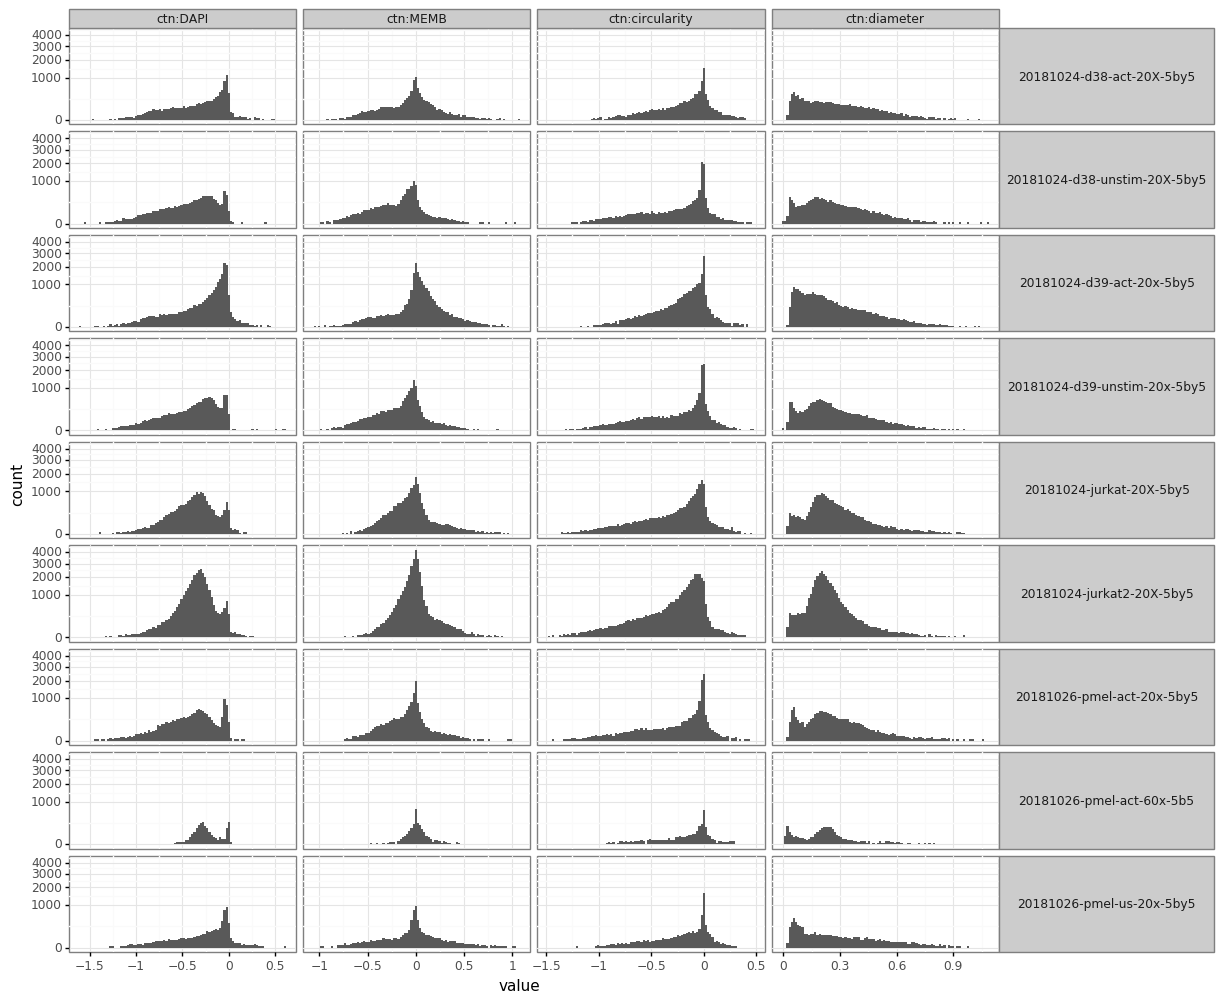

<ggplot: (8756297262947)>

In [43]:
(
    pn.ggplot(
        #df.filter(items=['exp', 'cell_circularity', 'nucleus_circularity', 'ni:DAPI', 'ci:MEMB']).melt(id_vars='exp'),
        df.filter(regex='^ctn:|^exp$').melt(id_vars='exp'),
        pn.aes(x='value')
    ) +
    pn.geom_histogram(bins=96) + 
    pn.facet_grid('exp ~ variable', scales='free_x') + 
    pn.scale_y_sqrt() +
    pn.theme_bw() + 
    pn.theme(
        figure_size=(12, 12),
        strip_text_y = pn.element_text(rotation=0, margin=dict(l=75, r=75))
    )
)

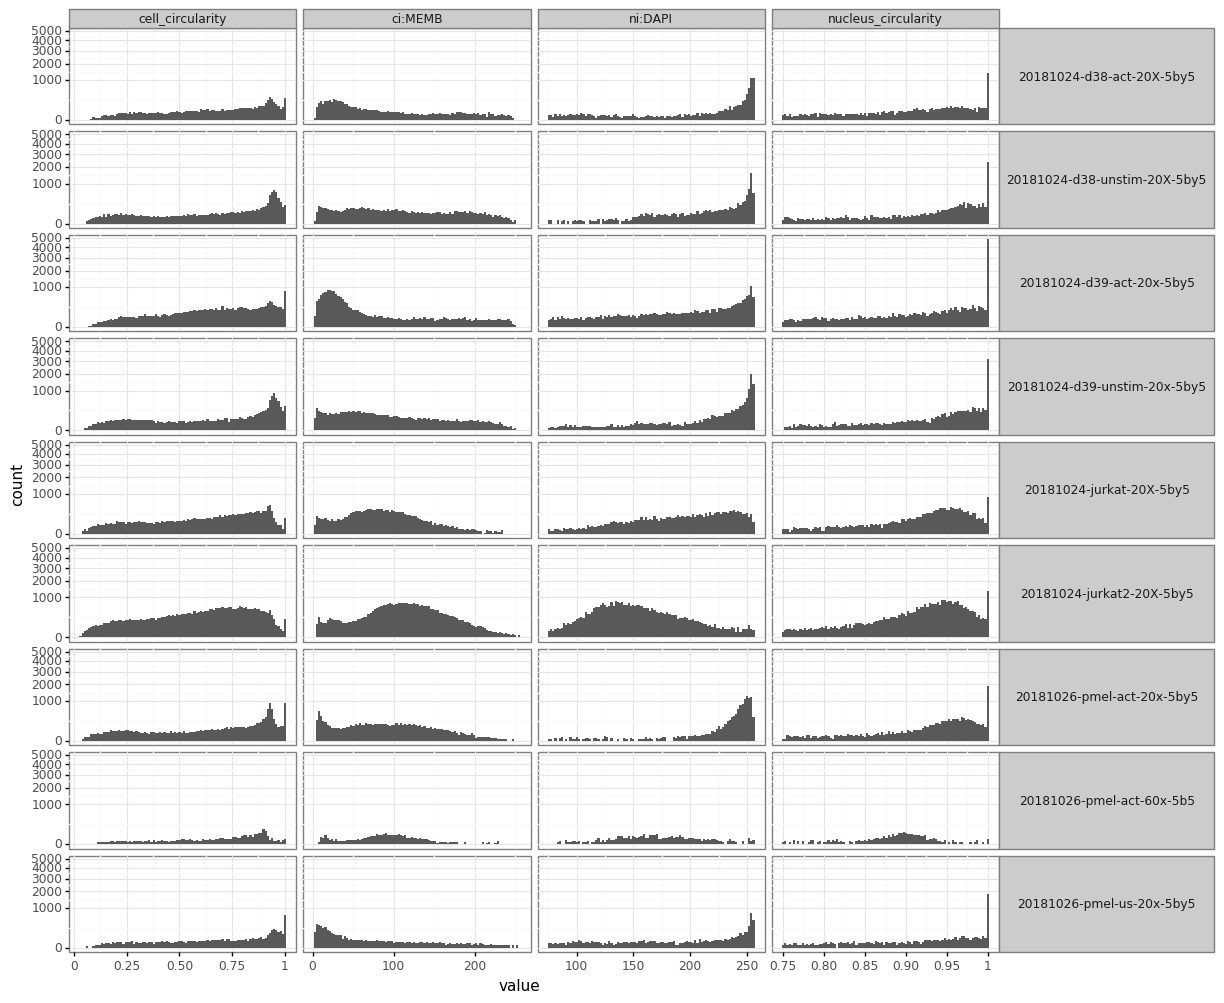

<ggplot: (-9223363280556725742)>

In [42]:
(
    pn.ggplot(
        df[(df['ni:DAPI'] > 75) & (df['nucleus_circularity'] > .75)]
            .filter(items=['exp', 'cell_circularity', 'nucleus_circularity', 'ni:DAPI', 'ci:MEMB']).melt(id_vars='exp'),
        #df.filter(regex='^ctn:|^exp$').melt(id_vars='exp'),
        pn.aes(x='value')
    ) +
    pn.geom_histogram(bins=96) + 
    pn.facet_grid('exp ~ variable', scales='free_x') + 
    pn.scale_y_sqrt() +
    pn.theme_bw() + 
    pn.theme(
        figure_size=(12, 12),
        strip_text_y = pn.element_text(rotation=0, margin=dict(l=75, r=75))
    )
)

In [4]:
def filter_df(df):
    df = df[df['cell_circularity'] > .75]
    df = df[df['nucleus_circularity'] > .75]
    df = df[df['ni:DAPI']>100]
    df = df[df['ci:MEMB']>75]
    
#     df = df[df['cg:n_neighbors'] < 1]
#     df = df[df['cell_circularity'] > .9]
#     df = df[df['nucleus_circularity'] > .9]
#     df = df[df['ni:DAPI']>100]
#     df = df[df['ci:MEMB']>100]
    return df.copy()

def get_replicate(exp):
    if exp == '20181024-jurkat2-20X-5by5':
        return 'R2'
    return 'R1'

def rename_exp(exp):
    if exp == '20181024-jurkat2-20X-5by5':
        return '20181024-jurkat-20X-5by5'
    return exp

df_ms = filter_df(df)[['exp', 'variant', 'cell_diameter', 'id']]
df_ms['replicate'] = df_ms['exp'].apply(get_replicate)
df_ms['exp'] = df_ms['exp'].apply(rename_exp)

df_ms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27445 entries, 0 to 682
Data columns (total 5 columns):
exp              27445 non-null object
variant          27445 non-null object
cell_diameter    27445 non-null float64
id               27445 non-null int64
replicate        27445 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


In [5]:
df_ms.groupby(['exp', 'replicate', 'variant']).size()

exp                           replicate  variant
20181024-d38-act-20X-5by5     R1         v00         503
                                         v01         502
                                         v02         291
20181024-d38-unstim-20X-5by5  R1         v00        1516
                                         v01        1103
                                         v02         746
20181024-d39-act-20x-5by5     R1         v00         657
                                         v01         631
                                         v02         471
20181024-d39-unstim-20x-5by5  R1         v00        1467
                                         v01        1085
                                         v02         941
20181024-jurkat-20X-5by5      R1         v00        1804
                                         v01        1124
                                         v02        1086
                              R2         v00        3147
                                       

In [6]:
df_ms.head()

,exp,variant,cell_diameter,id,replicate
0,20181024-d38-act-20X-5by5,v00,10.388761,1,R1
5,20181024-d38-act-20X-5by5,v00,10.849947,6,R1
12,20181024-d38-act-20X-5by5,v00,19.632913,13,R1
16,20181024-d38-act-20X-5by5,v00,10.749172,17,R1
19,20181024-d38-act-20X-5by5,v00,6.652735,20,R1


In [7]:
df_stats = df_ms.groupby(['exp', 'variant'])['cell_diameter'].describe()
df_stats

count       mean       std       min  \
exp                          variant                                          
20181024-d38-act-20X-5by5    v00       503.0  11.184297  3.024814  4.151137   
                             v01       502.0  13.744509  4.295069  4.151137   
                             v02       291.0  12.665103  5.953507  4.151137   
20181024-d38-unstim-20X-5by5 v00      1516.0   9.850160  2.121950  3.663710   
                             v01      1103.0  11.797784  3.243518  3.663710   
                             v02       746.0   9.967476  3.206044  3.638871   
20181024-d39-act-20x-5by5    v00       657.0   9.935152  2.205151  2.950706   
                             v01       631.0  11.282769  3.871369  2.950706   
                             v02       471.0   9.195813  2.847138  2.950706   
20181024-d39-unstim-20x-5by5 v00      1467.0  10.068453  2.156505  3.071192   
                             v01      1085.0  10.756011  3.184875  3.071192   
                             v02       941.0   9.169628  2.057556  3.071192   
20181024-jurkat-20X-5by5     v00      4951.0  12.020716  1.776183  3.215457   
                             v01      3917.0  12.570336  2.308426  3.215457   
                             v02      3885.0  12.137543  2.309349  3.215457   
20181026-pmel-act-20x-5by5   v00      1610.0  12.324890  1.826012  3.407182   
                             v01      1215.0  13.700458  2.743321  4.742596   
                             v02       809.0  12.045682  2.614238  4.723434   
20181026-pmel-act-60x-5b5    v00       239.0  11.464725  1.549166  4.866346   
                             v01       241.0  11.953305  1.504541  4.866346   
                             v02       227.0  12.363365  1.536127  4.866346   
20181026-pmel-us-20x-5by5    v00       192.0   8.391710  2.456014  3.663710   
                             v01       120.0   8.660153  3.492237  3.663710   
                             v02       126.0   7.652360  2.131475  3.663710   

                                            25%        50%        75%  \
exp                          variant                                    
20181024-d38-act-20X-5by5    v00       9.129521  10.916614  12.702119   
                             v01      10.197114  14.329415  16.646825   
                             v02       8.318643  10.380028  16.754081   
20181024-d38-unstim-20X-5by5 v00       8.156245   9.580332  11.300343   
                             v01       9.129521  11.810505  14.486783   
                             v02       7.947870   9.291970  10.839493   
20181024-d39-act-20x-5by5    v00       8.324094   9.841831  11.380318   
                             v01       8.001883  10.327470  14.571052   
                             v02       7.480536   8.811040  10.279055   
20181024-d39-unstim-20x-5by5 v00       8.665736   9.814147  11.207665   
                             v01       8.334982   9.786384  13.373459   
                             v02       7.945018   8.862357  10.042519   
20181024-jurkat-20X-5by5     v00      10.883332  12.008502  13.099383   
                             v01      10.974616  12.453412  14.035251   
                             v02      10.621858  11.833520  13.339507   
20181026-pmel-act-20x-5by5   v00      11.268194  12.365710  13.436040   
                             v01      11.616940  13.885832  15.778345   
                             v02      10.536127  11.756628  13.002092   
20181026-pmel-act-60x-5b5    v00      10.556669  11.522000  12.340415   
                             v01      11.077889  11.919219  12.843011   
                             v02      11.552134  12.352665  13.306226   
20181026-pmel-us-20x-5by5    v00       6.991721   7.582883   8.989161   
                             v01       6.521838   7.468284   9.318747   
                             v02       6.263010   7.120240   8.555134   

                                            max  
exp                          varian

## Load Counter Results

In [8]:
df_ct = pd.read_csv('cell_counter_results.csv')
df_ct['exp'] = df_ct['File'].map(file_map)
df_ct = df_ct.rename(columns={'Replicate': 'replicate', 'Avg size': 'value'})
assert df_ct['exp'].notnull().all()
df_ct

,File,Donor,State,replicate,Concentration,Live percent,value,exp
0,20181023-d38-act1.tiff,Donor 38,Activated (7 days),R1,2050000.0,0.39,11.38,20181024-d38-act-20X-5by5
1,20181023-d38-act2.tiff,Donor 38,Activated (7 days),R2,2240000.0,0.32,11.49,20181024-d38-act-20X-5by5
2,20181023-d38-unstim1.tiff,Donor 38,Unstimulated,R1,3200000.0,0.80,10.18,20181024-d38-unstim-20X-5by5
3,20181023-d38-unstim2.tiff,Donor 38,Unstimulated,R2,3740000.0,0.80,10.22,20181024-d38-unstim-20X-5by5
4,20181023-d39-act1.tiff,Donor 39,Activated (7 days),R1,2830000.0,0.30,9.95,20181024-d39-act-20x-5by5
5,20181023-d39-act2.tiff,Donor 39,Activated (7 days),R2,3520000.0,0.34,10.45,20181024-d39-act-20x-5by5
6,20181023-d39-us1.tiff,Donor 39,Unstimulated,R1,4290000.0,0.85,10.60,20181024-d39-unstim-20x-5by5
7,20181023-d39-us2.tiff,Donor 39,Unstimulated,R2,4290000.0,0.82,10.27,20181024-d39-unstim-20x-5by5
8,20181023-jurkat1.tiff,Jurkat,Unstimulated,R1,809000.0,0.91,14.48,20181024-jurkat-20X-5by5
9,20181023-jurkat2.tiff,Jurkat,Unstimulated,R2,727000.0,0.94,14.40,20181024-jurkat-20X-5by5


## Visualization

In [9]:
df_ms.head()

,exp,variant,cell_diameter,id,replicate
0,20181024-d38-act-20X-5by5,v00,10.388761,1,R1
5,20181024-d38-act-20X-5by5,v00,10.849947,6,R1
12,20181024-d38-act-20X-5by5,v00,19.632913,13,R1
16,20181024-d38-act-20X-5by5,v00,10.749172,17,R1
19,20181024-d38-act-20X-5by5,v00,6.652735,20,R1


In [10]:
df_ct.head()

,File,Donor,State,replicate,Concentration,Live percent,value,exp
0,20181023-d38-act1.tiff,Donor 38,Activated (7 days),R1,2050000.0,0.39,11.38,20181024-d38-act-20X-5by5
1,20181023-d38-act2.tiff,Donor 38,Activated (7 days),R2,2240000.0,0.32,11.49,20181024-d38-act-20X-5by5
2,20181023-d38-unstim1.tiff,Donor 38,Unstimulated,R1,3200000.0,0.80,10.18,20181024-d38-unstim-20X-5by5
3,20181023-d38-unstim2.tiff,Donor 38,Unstimulated,R2,3740000.0,0.80,10.22,20181024-d38-unstim-20X-5by5
4,20181023-d39-act1.tiff,Donor 39,Activated (7 days),R1,2830000.0,0.30,9.95,20181024-d39-act-20x-5by5


In [21]:
def plot_results(df_ms, df_ct, variants=['v01'], figsize=(12, 4)):
    df_ms = df_ms[df_ms['variant'].isin(variants)]
    df_ms_stat = df_ms.groupby(['exp', 'variant', 'replicate'])['cell_diameter'].agg(['mean', 'std', 'count']) \
        .assign(lo=lambda df: df['mean'] - 1*df['std']) \
        .assign(hi=lambda df: df['mean'] + 1*df['std']).reset_index()
    
    theme_opts = dict(
        axis_text_x = pn.element_text(angle = 90, hjust = 0), 
        figure_size=figsize
    )
    if len(variants) < 2:
        theme_opts['strip_text_x'] = pn.element_blank()
    return (
        pn.ggplot(df_ms, pn.aes(x='exp', y='cell_diameter', fill='replicate')) +
        pn.geom_violin() +
        pn.geom_point(
            data=df_ms_stat,
            mapping=pn.aes(x='exp', y='mean', group='replicate'),
            fill='black',
            position=pn.position_dodge(width=.9)
        ) +
        pn.geom_errorbar(
            data=df_ms_stat, 
            mapping=pn.aes(x='exp', y='mean', ymin='lo', ymax='hi', fill='replicate'),
            position=pn.position_dodge(width=.9),
            width=.1
        ) +
        pn.geom_text(
            data=df_ms_stat.assign(ctstr=lambda df: df['count'].astype(str)),
            mapping=pn.aes(x='exp', y=0, label='count'),
            position=pn.position_dodge(width=.9)
        ) +
        pn.geom_jitter(
            data=df_ct, 
            mapping=pn.aes(x='exp', y='value', group='replicate'),
            width=.3,
            size=3,
            random_state=1
        ) +
        pn.scale_fill_brewer(palette='Blues', guide=pn.guide_legend(title='Replicate')) +
        pn.xlab('Experiment') +
        pn.ylab('Cell Diameter (µm)') +
        pn.ylim(0, 20) + 
        pn.facet_wrap('~variant', scales='free_y', ncol=1) +
        pn.theme_bw() +
        pn.theme(**theme_opts)
    )

/usr/local/lib/python3.5/dist-packages/plotnine/layer.py:360: UserWarning: stat_ydensity : Removed 212 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


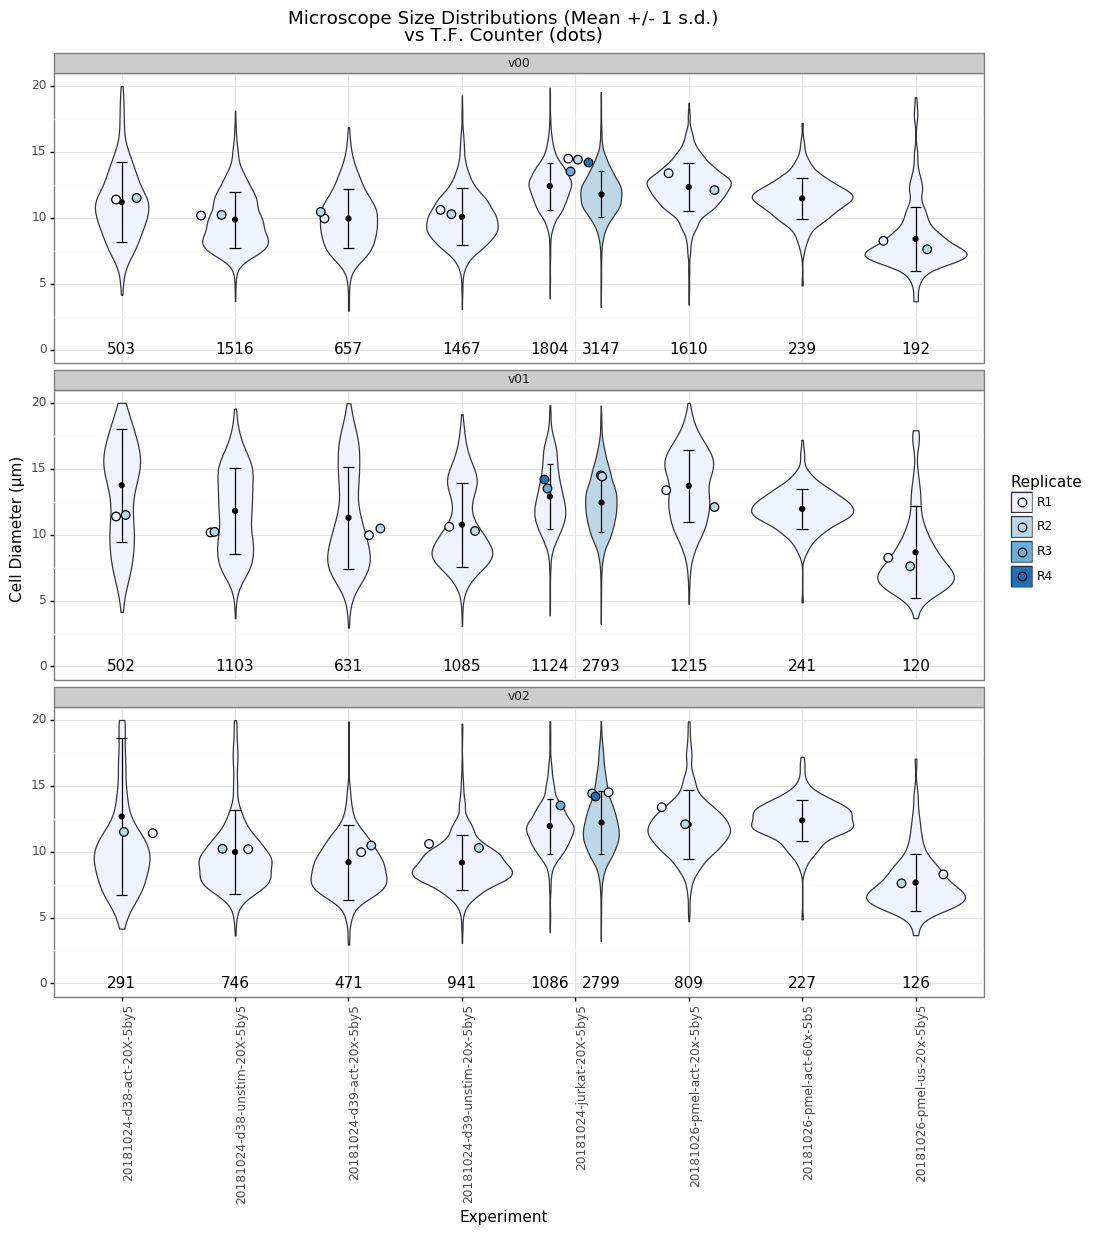

<ggplot: (-9223363273050386716)>

In [22]:
plot_results(df_ms, df_ct, variants=['v00', 'v01', 'v02'], figsize=(12, 4 * 3)) + \
   pn.ggtitle('Microscope Size Distributions (Mean +/- 1 s.d.)\nvs T.F. Counter (dots)')

/usr/local/lib/python3.5/dist-packages/plotnine/layer.py:360: UserWarning: stat_ydensity : Removed 20 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


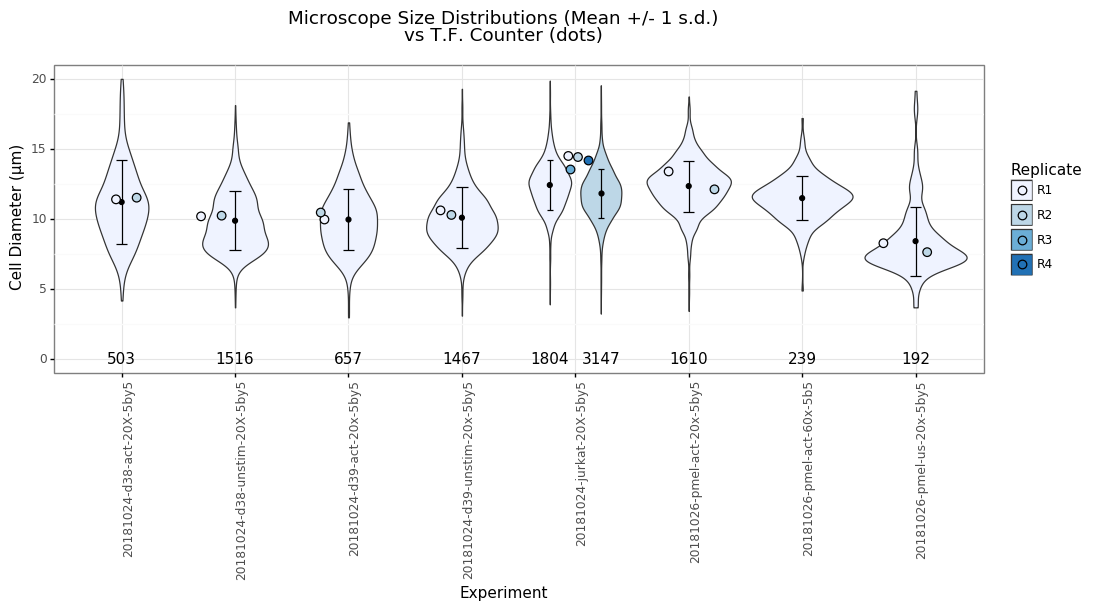

<ggplot: (8763803963589)>

In [23]:
# Best variant
plot_results(df_ms, df_ct, variants=['v00']) + \
   pn.ggtitle('Microscope Size Distributions (Mean +/- 1 s.d.)\nvs T.F. Counter (dots)')

In [18]:
from scipy.stats import wilcoxon, ttest_1samp, ttest_ind
def getp(g):
    exp = g['exp'].iloc[0]
    x = g['cell_diameter']
    
    # TODO: Figure out how to do t-test for sample against sample of means
    x0 = df_ct[df_ct['exp'] == exp]['value']
    #return wilcoxon(x - x0.mean())[1]
    #return ttest_1samp(x, x0.mean())[1]
    return ttest_ind(x, x0)[1]
df_ms.groupby(['exp', 'replicate', 'variant']).apply(getp).unstack().round(5)

variant                                     v00      v01      v02
exp                          replicate                           
20181024-d38-act-20X-5by5    R1         0.90683  0.44780  0.77072
20181024-d38-unstim-20X-5by5 R1         0.81573  0.48636  0.91839
20181024-d39-act-20x-5by5    R1         0.86528  0.69281  0.61853
20181024-d39-unstim-20x-5by5 R1         0.81014  0.88673  0.38493
20181024-jurkat-20X-5by5     R1         0.04894  0.31084  0.03403
                             R2         0.00682  0.12242  0.10400
20181026-pmel-act-20x-5by5   R1         0.75384  0.61713  0.71153
20181026-pmel-act-60x-5b5    R1             NaN      NaN      NaN
20181026-pmel-us-20x-5by5    R1         0.79118  0.76892  0.85473